In [ ]:
import tensorflow as tf
import os
import glob
from matplotlib import pyplot as plt
%matplotlib inline
import time

In [ ]:
from google.colab import drive #mouting drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
imgs_path = glob.glob('/content/drive/MyDrive/data/data/train/*.png')

In [ ]:
len(imgs_path)

14224

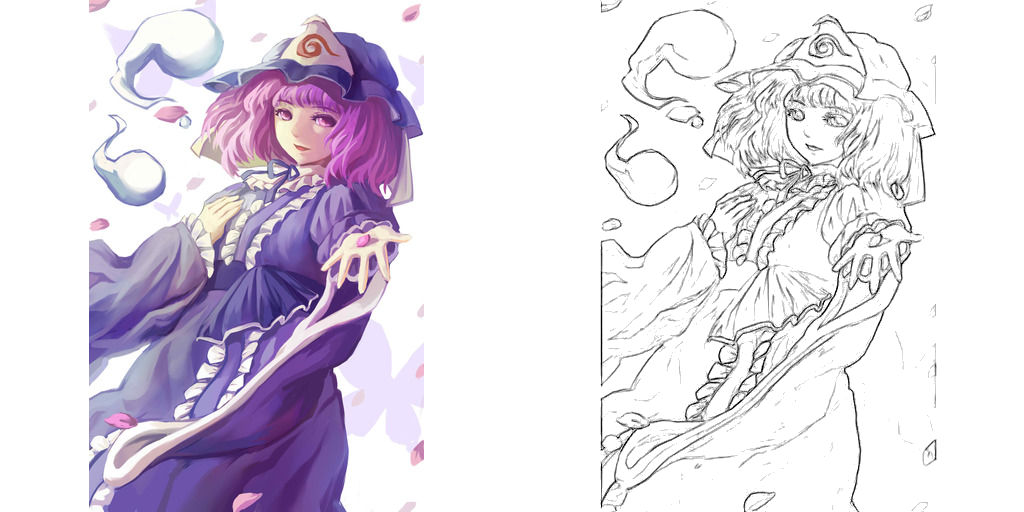

In [ ]:
import random
img = tf.keras.preprocessing.image.load_img(random.choice(imgs_path))
img #random image from training set

In [ ]:
imgs_path[:3]

['/content/drive/MyDrive/data/data/train/2942082.png',
 '/content/drive/MyDrive/data/data/train/2944011.png',
 '/content/drive/MyDrive/data/data/train/2943147.png']

In [ ]:
tf.__version__

'2.8.0'

In [ ]:
def read_jpg(path): 
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [ ]:
def normalize(input_image, input_mask): #normalize  
    input_image = tf.cast(input_image, tf.float32)/127.5 - 1
    input_mask = tf.cast(input_mask, tf.float32)/127.5 - 1
    return input_image, input_mask

In [ ]:
def load_image(image_path):
    image = read_jpg(image_path)
    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, :w, :]
    input_mask = image[:, w:, :]
    input_image = tf.image.resize(input_image, (256, 256))
    input_mask = tf.image.resize(input_mask, (256, 256))
    
    if tf.random.uniform(()) > 0.5: #randomly mirror half images for better training
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_mask, input_image

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(imgs_path)

In [ ]:
train = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
train

<ParallelMapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None))>

In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 200

In [ ]:
train_dataset = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

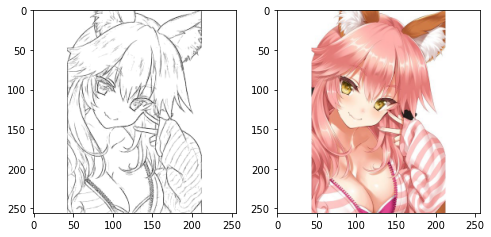

In [ ]:
plt.figure(figsize=(8, 5))
for img, musk in train_dataset.take(1):
    plt.subplot(1,2,1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))
    plt.subplot(1,2,2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(musk[0]))

In [ ]:
imgs_path_test = glob.glob('/content/drive/MyDrive/data/data/val/*.png')

In [ ]:
len(imgs_path_test)

3545

In [ ]:
dataset_test = tf.data.Dataset.from_tensor_slices(imgs_path_test)

In [ ]:
def load_image_test(image_path):
    image = read_jpg(image_path)
    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, :w, :]
    input_mask = image[:, w:, :]
    input_image = tf.image.resize(input_image, (256, 256))
    input_mask = tf.image.resize(input_mask, (256, 256))
    
    input_image, input_mask = normalize(input_image, input_mask)

    return input_mask, input_image

In [ ]:
dataset_test = dataset_test.map(load_image_test)

In [ ]:
dataset_test = dataset_test.batch(BATCH_SIZE)

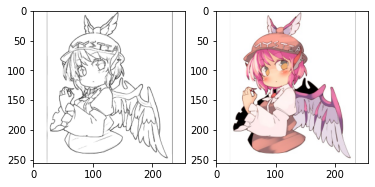

In [ ]:
for img, musk in dataset_test.take(1):
    plt.subplot(1,2,1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))
    plt.subplot(1,2,2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(musk[0]))

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
def downsample(filters, size, apply_batchnorm=True): #convolution block with normalisation and activation
#    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                               use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

        result.add(tf.keras.layers.LeakyReLU())

    return result

In [ ]:
def upsample(filters, size, apply_dropout=False): #deconv block with activation and norm
#    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        use_bias=False))

    result.add(tf.keras.layers.BatchNormalization()) 

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [ ]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64) no norm
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

#    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x). 

    skips = reversed(skips[:-1]) #skips now has comv blocks in reverse order

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

        #sequentially connect upsample and downsample blocks
    x = last(x)

   


    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
generator = Generator()
#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [ ]:
LAMBDA = 10

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss) #regularization term

    return total_gen_loss, gan_loss, l1_loss

In [ ]:
def Discriminator():
#    initializer = tf.random_normal_initializer(0., 0.02)
#.   Cannot use sequential here because two inputa
    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  padding='same',
                                  use_bias=False)(down3) # (bs, 32, 32, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv) # batchnorm

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1) #activation

    last = tf.keras.layers.Conv2D(1, 4, strides=1, padding='same')(leaky_relu) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [ ]:
discriminator = Discriminator()
#tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output) #log(D(x))

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output) #log(1-D(G(h)) 

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

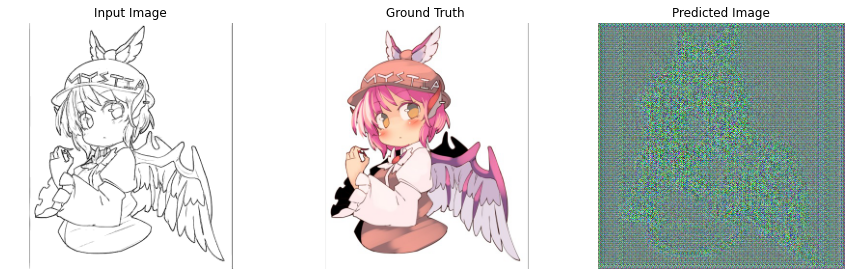

In [ ]:
for example_input, example_target in dataset_test.take(1):
    generate_images(generator, example_input, example_target)

In [ ]:
EPOCHS = 100

In [ ]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)  #G(h)

        disc_real_output = discriminator([input_image, target], training=True) #D(x,h)
        disc_generated_output = discriminator([input_image, gen_output], training=True) #D(G(z),h)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
#.   Calculating gradient
    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)
#.   Gradient descent
    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
    return gen_total_loss, disc_loss

In [ ]:
epoch_loss_avg_gen = tf.keras.metrics.Mean('g_loss')
epoch_loss_avg_disc = tf.keras.metrics.Mean('d_loss')

In [ ]:
g_loss_results = []
d_loss_results = []

In [ ]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs+1):
        if epoch%10 == 0:
            for example_input, example_target in test_ds.take(1):
                generate_images(generator, example_input, example_target)
        print("Epoch: ", epoch)
        #train in batches
        for n, (input_image, target) in train_ds.enumerate():
            print('.', end='')
            g_loss, d_loss = train_step(input_image, target, epoch)
            epoch_loss_avg_gen(g_loss)
            epoch_loss_avg_disc(d_loss)
        print()
        g_loss_results.append(epoch_loss_avg_gen.result())
        d_loss_results.append(epoch_loss_avg_disc.result())
        
        epoch_loss_avg_gen.reset_states()
        epoch_loss_avg_disc.reset_states()

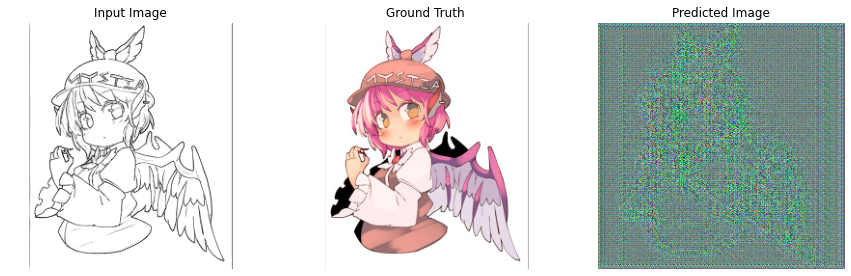

Epoch:  0
..............................................................................................
Epoch:  1
..............................................................................................
Epoch:  2
..............................................................................................
Epoch:  3
..............................................................................................
Epoch:  4
..............................................................................................
Epoch:  5
..............................................................................................
Epoch:  6
..............................................................................................
Epoch:  7
..............................................................................................
Epoch:  8
..............................................................................................
Epoch:  9
.............................................

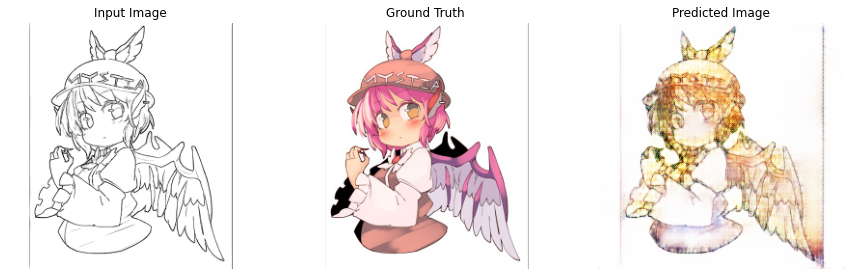

Epoch:  10
..............................................................................................
Epoch:  11
..............................................................................................
Epoch:  12
..............................................................................................
Epoch:  13
..............................................................................................
Epoch:  14
..............................................................................................
Epoch:  15
..............................................................................................
Epoch:  16
..............................................................................................
Epoch:  17
..............................................................................................
Epoch:  18
..............................................................................................
Epoch:  19
...................................

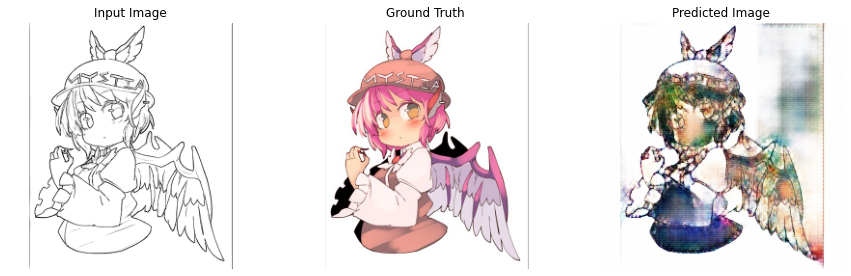

Epoch:  20
..............................................................................................
Epoch:  21
..............................................................................................
Epoch:  22
..............................................................................................
Epoch:  23
..............................................................................................
Epoch:  24
..............................................................................................
Epoch:  25
..............................................................................................
Epoch:  26
..............................................................................................
Epoch:  27
..............................................................................................
Epoch:  28
..............................................................................................
Epoch:  29
...................................

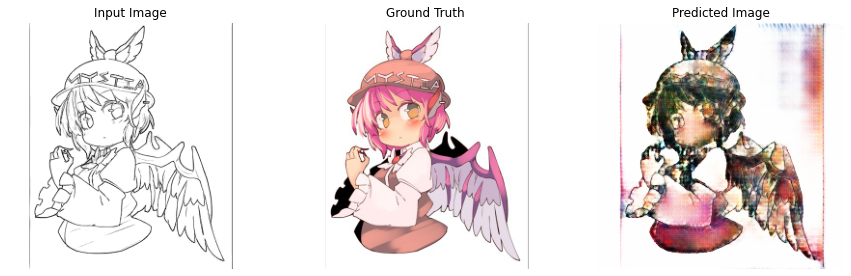

Epoch:  30
..............................................................................................
Epoch:  31
..............................................................................................
Epoch:  32
..............................................................................................
Epoch:  33
..............................................................................................
Epoch:  34
..............................................................................................
Epoch:  35
..............................................................................................
Epoch:  36
..............................................................................................
Epoch:  37
..............................................................................................
Epoch:  38
..............................................................................................
Epoch:  39
...................................

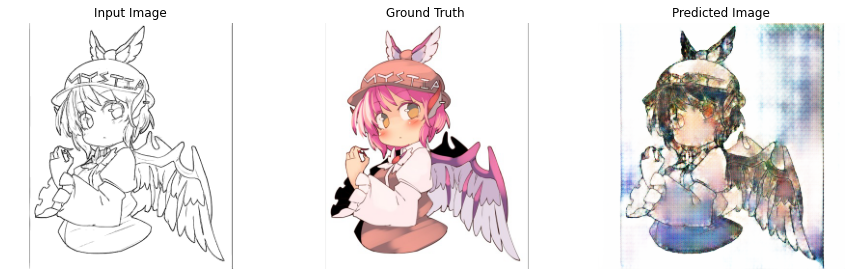

Epoch:  40
..............................................................................................
Epoch:  41
..............................................................................................
Epoch:  42
..............................................................................................
Epoch:  43
..............................................................................................
Epoch:  44
..............................................................................................
Epoch:  45
..............................................................................................
Epoch:  46
..............................................................................................
Epoch:  47
..............................................................................................
Epoch:  48
..............................................................................................
Epoch:  49
...................................

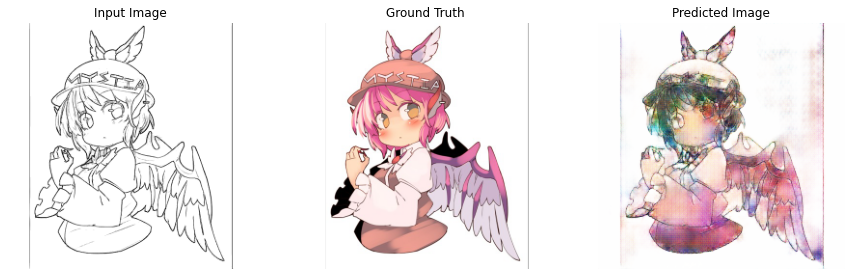

Epoch:  50
..............................................................................................
Epoch:  51
..............................................................................................
Epoch:  52
..............................................................................................
Epoch:  53
..............................................................................................
Epoch:  54
..............................................................................................
Epoch:  55
..............................................................................................
Epoch:  56
..............................................................................................
Epoch:  57
..............................................................................................
Epoch:  58
..............................................................................................
Epoch:  59
...................................

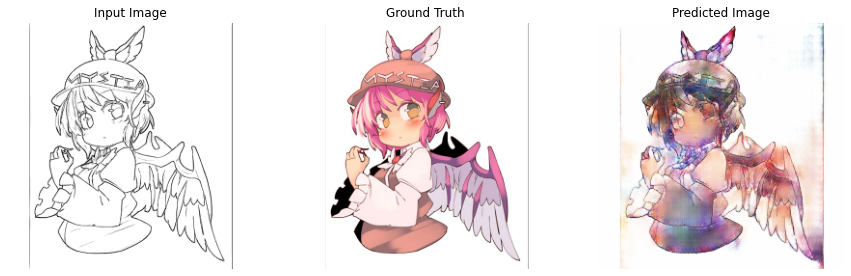

Epoch:  60
..............................................................................................
Epoch:  61
..............................................................................................
Epoch:  62
..............................................................................................
Epoch:  63
..............................................................................................
Epoch:  64
..............................................................................................
Epoch:  65
..............................................................................................
Epoch:  66
..............................................................................................
Epoch:  67
..................................................................................

NotFoundError: ignored

In [ ]:
fit(train_dataset, EPOCHS, dataset_test)

In [ ]:
plt.plot(range(1, len(g_loss_results)+1), g_loss_results, label='g_loss')
plt.plot(range(1, len(d_loss_results)+1), d_loss_results, label='d_loss')
plt.legend()

In [ ]:
generator.save("/content/drive/MyDrive/Anime GAN")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Anime GAN/assets


In [ ]:
discriminator.save("/content/drive/MyDrive/Anime GAN")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Anime GAN/assets
